解决方案思路
一、采用时间序列进行预测
思想：采用ARIMA模型进行平稳性检测以及预测

二、基于时序规则的挖掘
思想：使用base与周期因子结合的方式对目标进行预测

三、对一、二对结果进行模型融合，提升准确率

In [13]:
import pandas as pd

#数据加载
data = pd.read_csv('user_balance_table.csv', parse_dates=['report_date'])
data.head(10)

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
5,1,2014-08-20,20415,20413,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
6,1,2014-08-23,20421,20419,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
7,1,2014-08-26,20427,20425,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
8,1,2014-08-29,20433,20431,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
9,1,2014-08-30,20435,20433,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [3]:
#数据缺失情况
data.isnull().sum()

user_id                      0
report_date                  0
tBalance                     0
yBalance                     0
total_purchase_amt           0
direct_purchase_amt          0
purchase_bal_amt             0
purchase_bank_amt            0
total_redeem_amt             0
consume_amt                  0
transfer_amt                 0
tftobal_amt                  0
tftocard_amt                 0
share_amt                    0
category1              2666682
category2              2666682
category3              2666682
category4              2666682
dtype: int64

In [12]:
total_balance = data.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()
total_balance.reset_index().head()

<ipython-input-12-39484a7e1e16>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_balance = data.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()


,report_date,total_purchase_amt,total_redeem_amt
0,2013-07-01,32488348,5525022
1,2013-07-02,29037390,2554548
2,2013-07-03,27270770,5953867
3,2013-07-04,18321185,6410729
4,2013-07-05,11648749,2763587


In [7]:
purchase = total_balance[['total_purchase_amt']]
redeem = total_balance[['total_redeem_amt']]

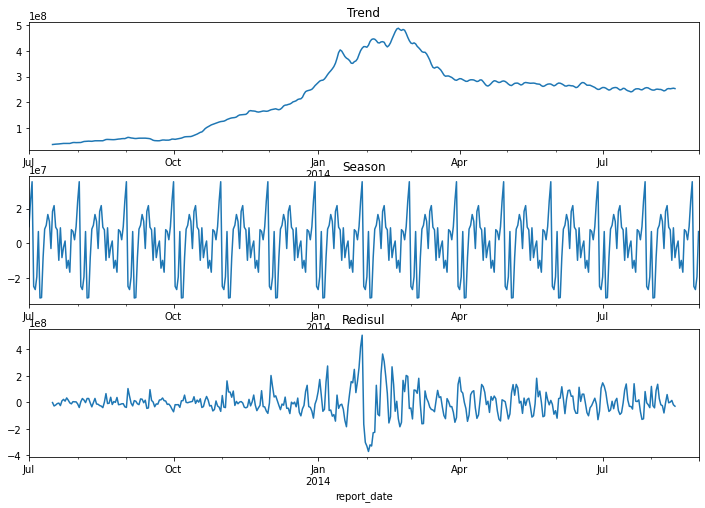

In [59]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 对指定区间范围内的数据可视化
def plot_stl(data):
    result = sm.tsa.seasonal_decompose(data, period=30)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    
    result.trend.plot(ax=ax1,title='Trend')
    result.seasonal.plot(ax=ax2,title='Season')
    result.resid.plot(ax=ax3,title='Redisul')
    
plot_stl(purchase.total_purchase_amt)

In [11]:
purchase2 = purchase[(purchase.index >= '2014-04-01') & (purchase.index <= '2014-05-07')]
purchase2.reset_index().head()

,report_date,total_purchase_amt
0,2014-04-01,453320585
1,2014-04-02,355347118
2,2014-04-03,363877120
3,2014-04-04,251895894
4,2014-04-05,202336542


In [14]:
from statsmodels.tsa.stattools import adfuller

trend = adfuller(purchase['total_purchase_amt'])
trend

(-1.5898802926313507,
 0.4886749751375928,
 18,
 408,
 {'1%': -3.446479704252724,
  '5%': -2.8686500930967354,
  '10%': -2.5705574627547096},
 15960.28197033403)

In [16]:
#一阶差分
diff1 = purchase.diff(1)

t = adfuller(diff1[1:])
t2 = adfuller(redeem['total_redeem_amt'])

diff2 = redeem.diff(1)

In [17]:
t2 = adfuller(diff2[1:])
t2

(-11.69198690696882,
 1.6443717458499181e-21,
 12,
 413,
 {'1%': -3.4462831955497135,
  '5%': -2.8685636962704395,
  '10%': -2.5705114078759914},
 15779.04993673871)

In [18]:
from statsmodels.tsa.arima_model import ARIMA
from itertools import product
from sklearn.model_selection import learning_curve,GridSearchCV
# p,d,q其中d=1

# 设置参数范围
ps = range(0, 10)
qs = range(0, 10)
ds = range(0, 1)
parameters = product(ps, ds, qs)
parameters_list = list(parameters)
# 寻找最优ARIMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
i=1
for param in parameters_list:
    print('第{}次循环'.format(i))
    try:
        # SARIMAX 包含季节趋势因素的ARIMA模型
        model = ARIMA(purchase,order=(param[0], param[1], param[2])).fit()

    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    i+=1
# 输出最优模型
print('最优模型: ', best_model.summary())

第1次循环
第2次循环
第3次循环
第4次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第5次循环
第6次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第7次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第8次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第9次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第10次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第11次循环
第12次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第13次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第14次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第15次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第16次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第17次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第18次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第19次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第20次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第21次循环
第22次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第23次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第24次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第25次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第26次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第27次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第28次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第29次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第30次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第31次循环
第32次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第33次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第34次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第35次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第36次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第37次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第38次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第39次循环
参数错误: (3, 0, 8)
第39次循环
参数错误: (3, 0, 9)
第39次循环
第40次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第41次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第42次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第43次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第44次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第45次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第46次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第47次循环
参数错误: (4, 0, 8)
第47次循环
参数错误: (4, 0, 9)
第47次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第48次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第49次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第50次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第51次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第52次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第53次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was pr

第54次循环
参数错误: (5, 0, 7)
第54次循环
参数错误: (5, 0, 8)
第54次循环
参数错误: (5, 0, 9)
第54次循环
第55次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第56次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第57次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第58次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第59次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第60次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第61次循环
参数错误: (6, 0, 7)
第61次循环
参数错误: (6, 0, 8)
第61次循环
参数错误: (6, 0, 9)
第61次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第62次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第63次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第64次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第65次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第66次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第67次循环
参数错误: (7, 0, 6)
第67次循环
参数错误: (7, 0, 7)
第67次循环
参数错误: (7, 0, 8)
第67次循环
参数错误: (7, 0, 9)
第67次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information

第68次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第69次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第70次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第71次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第72次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第73次循环
参数错误: (8, 0, 6)
第73次循环
参数错误: (8, 0, 7)
第73次循环
参数错误: (8, 0, 8)
第73次循环
参数错误: (8, 0, 9)
第73次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information

第74次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第75次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第76次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


第77次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第78次循环


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


第79次循环
参数错误: (9, 0, 6)
第79次循环
参数错误: (9, 0, 7)
第79次循环
参数错误: (9, 0, 8)
第79次循环
参数错误: (9, 0, 9)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


最优模型:                                ARMA Model Results                              
Dep. Variable:     total_purchase_amt   No. Observations:                  427
Model:                     ARMA(9, 4)   Log Likelihood               -8332.745
Method:                       css-mle   S.D. of innovations       71737762.584
Date:                Fri, 04 Dec 2020   AIC                          16695.490
Time:                        22:22:48   BIC                          16756.342
Sample:                    07-01-2013   HQIC                         16719.525
                         - 08-31-2014                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     2.168e+08   9.58e+07      2.263      0.024     2.9e+07    4.05e+08
ar.L1.total_purchase_amt     2.1154      0.117     18.022      0.000       1.885  

In [20]:
model = ARIMA(purchase,order=(9,1,4)).fit()

purchase_pred = model.predict('2014-09-01','2014-09-30',typ='levels')
purchase_pred

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


2014-09-01    3.181186e+08
2014-09-02    3.281598e+08
2014-09-03    3.089960e+08
2014-09-04    2.572027e+08
2014-09-05    2.284243e+08
2014-09-06    2.045714e+08
2014-09-07    2.420019e+08
2014-09-08    2.836045e+08
2014-09-09    3.136309e+08
2014-09-10    3.005492e+08
2014-09-11    2.639075e+08
2014-09-12    2.312903e+08
2014-09-13    2.245323e+08
2014-09-14    2.548097e+08
2014-09-15    2.961657e+08
2014-09-16    3.220677e+08
2014-09-17    3.101121e+08
2014-09-18    2.726879e+08
2014-09-19    2.365163e+08
2014-09-20    2.287342e+08
2014-09-21    2.547161e+08
2014-09-22    2.947029e+08
2014-09-23    3.196715e+08
2014-09-24    3.109999e+08
2014-09-25    2.766563e+08
2014-09-26    2.426266e+08
2014-09-27    2.350006e+08
2014-09-28    2.594250e+08
2014-09-29    2.979907e+08
2014-09-30    3.224195e+08
Freq: D, dtype: float64

In [21]:
model.aic #aic描绘了拟合优度

16655.157093476646

In [22]:
model2 = ARIMA(redeem,order=(9,1,4)).fit()

redeem_pred = model2.predict('2014-09-01','2014-09-30',typ='levels')
redeem_pred

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


2014-09-01    2.849035e+08
2014-09-02    3.107267e+08
2014-09-03    3.252732e+08
2014-09-04    2.970577e+08
2014-09-05    2.327507e+08
2014-09-06    2.048597e+08
2014-09-07    2.363203e+08
2014-09-08    2.883931e+08
2014-09-09    3.244603e+08
2014-09-10    3.308379e+08
2014-09-11    2.979485e+08
2014-09-12    2.489158e+08
2014-09-13    2.211039e+08
2014-09-14    2.429586e+08
2014-09-15    2.924691e+08
2014-09-16    3.348751e+08
2014-09-17    3.371793e+08
2014-09-18    3.023173e+08
2014-09-19    2.519024e+08
2014-09-20    2.274659e+08
2014-09-21    2.452228e+08
2014-09-22    2.957876e+08
2014-09-23    3.375829e+08
2014-09-24    3.433575e+08
2014-09-25    3.061805e+08
2014-09-26    2.578166e+08
2014-09-27    2.313876e+08
2014-09-28    2.508602e+08
2014-09-29    2.987862e+08
2014-09-30    3.430749e+08
Freq: D, dtype: float64

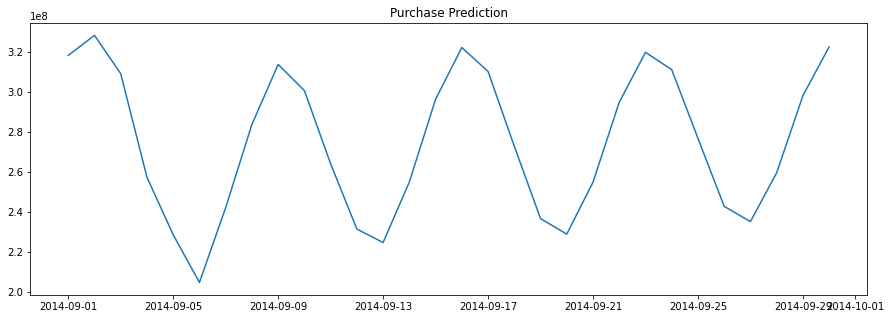

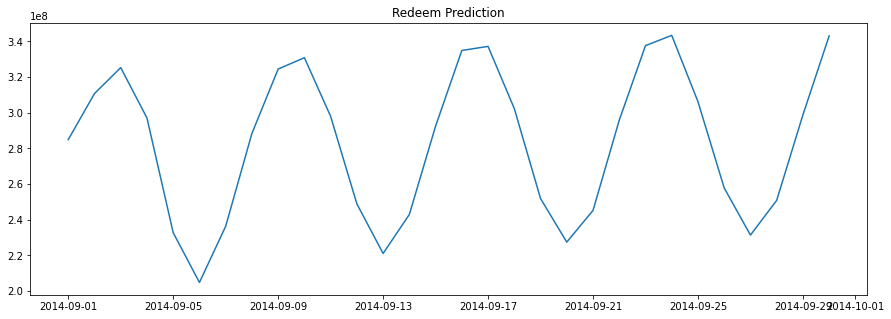

In [23]:
plt.figure(figsize=(15,5))
plt.title('Purchase Prediction')
plt.plot(purchase_pred)
plt.show()

plt.figure(figsize=(15,5))
plt.title('Redeem Prediction')
plt.plot(redeem_pred)
plt.show()

In [24]:
result = pd.DataFrame()
result['date'] = purchase_pred.index
result['purchase'] = purchase_pred.values
result['redeem'] = redeem_pred.values
result

,date,purchase,redeem
0,2014-09-01,3.181186e+08,2.849035e+08
1,2014-09-02,3.281598e+08,3.107267e+08
2,2014-09-03,3.089960e+08,3.252732e+08
3,2014-09-04,2.572027e+08,2.970577e+08
4,2014-09-05,2.284243e+08,2.327507e+08
5,2014-09-06,2.045714e+08,2.048597e+08
6,2014-09-07,2.420019e+08,2.363203e+08
7,2014-09-08,2.836045e+08,2.883931e+08
8,2014-09-09,3.136309e+08,3.244603e+08
9,2014-09-10,3.005492e+08,3.308379e+08


In [25]:
#将日期格式转换为预测结果提交要求的格式
result['date'] = result['date'].apply(lambda x:str(x).replace('-','')[0:8])
result

,date,purchase,redeem
0,20140901,3.181186e+08,2.849035e+08
1,20140902,3.281598e+08,3.107267e+08
2,20140903,3.089960e+08,3.252732e+08
3,20140904,2.572027e+08,2.970577e+08
4,20140905,2.284243e+08,2.327507e+08
5,20140906,2.045714e+08,2.048597e+08
6,20140907,2.420019e+08,2.363203e+08
7,20140908,2.836045e+08,2.883931e+08
8,20140909,3.136309e+08,3.244603e+08
9,20140910,3.005492e+08,3.308379e+08


In [53]:
result.to_csv('arima.csv',header=None,index=False)

In [19]:
# 给数据添加时间维度
def add_timestamp(data):
    # 时间格式转换
    data['report_date'] = pd.to_datetime(data['report_date'],format='%Y%m%d')
    # 添加时间维度
    data['day'] = data['report_date'].dt.day
    data['month'] = data['report_date'].dt.month
    data['year'] = data['report_date'].dt.year
    data['week'] = data['report_date'].dt.week #在一年中的第多少个week
    data['weekday'] = data['report_date'].dt.weekday
    return data

data = add_timestamp(data)
data

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,...,share_amt,category1,category2,category3,category4,day,month,year,week,weekday
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,5,8,2014,32,1
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,8,8,2014,32,4
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,11,8,2014,33,0
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,14,8,2014,33,3
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,17,8,2014,33,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840416,28033,2014-08-25,550646,550585,61,0,0,0,0,0,...,61,NaN,NaN,NaN,NaN,25,8,2014,35,0
2840417,28033,2014-08-31,525707,538147,60,0,0,0,12500,12500,...,60,0.0,0.0,0.0,12500.0,31,8,2014,35,6
2840418,28033,2014-07-24,20487121,20484824,2297,0,0,0,0,0,...,2297,NaN,NaN,NaN,NaN,24,7,2014,30,3
2840419,28033,2014-07-27,20462288,20491722,2298,0,0,0,31732,0,...,2298,NaN,NaN,NaN,NaN,27,7,2014,30,6


In [26]:
def get_total_balance(data,begin):
    df_temp = data.copy()
    df_temp = df_temp.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()
    df_temp.reset_index(inplace=True)
    df_temp = df_temp[(df_temp['report_date'] >= begin)]
    return df_temp
    
# 筛选从2014-03-01之后的数据作为平稳数据
total_balance = get_total_balance(data,'2014-03-01')

<ipython-input-26-1c281f48c961>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_temp = df_temp.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()


In [27]:
import datetime
import numpy as np

def generate_test_data(data):
    total_balance = data.copy()
    start = datetime.datetime(2014,9,1)
    end = datetime.datetime(2014,10,1)
    testdata = []
    while start != end:
        temp = [start, np.nan, np.nan]
        testdata.append(temp)
        start += datetime.timedelta(days=1)
    testdata = pd.DataFrame(testdata)
    testdata.columns = total_balance.columns
    total_balance = pd.concat([total_balance,testdata],axis=0)
    return total_balance

total_balance = generate_test_data(total_balance)
total_balance

,report_date,total_purchase_amt,total_redeem_amt
243,2014-03-01,362865580.0,211279011.0
244,2014-03-02,276202230.0,246199417.0
245,2014-03-03,505305862.0,513017360.0
246,2014-03-04,524146340.0,250562978.0
247,2014-03-05,454295491.0,209072753.0
...,...,...,...
25,2014-09-26,NaN,NaN
26,2014-09-27,NaN,NaN
27,2014-09-28,NaN,NaN
28,2014-09-29,NaN,NaN


In [28]:
# 对total_balance添加时间维度
total_balance = add_timestamp(total_balance)
total_balance

,report_date,total_purchase_amt,total_redeem_amt,day,month,year,week,weekday
243,2014-03-01,362865580.0,211279011.0,1,3,2014,9,5
244,2014-03-02,276202230.0,246199417.0,2,3,2014,9,6
245,2014-03-03,505305862.0,513017360.0,3,3,2014,10,0
246,2014-03-04,524146340.0,250562978.0,4,3,2014,10,1
247,2014-03-05,454295491.0,209072753.0,5,3,2014,10,2
...,...,...,...,...,...,...,...,...
25,2014-09-26,NaN,NaN,26,9,2014,39,4
26,2014-09-27,NaN,NaN,27,9,2014,39,5
27,2014-09-28,NaN,NaN,28,9,2014,39,6
28,2014-09-29,NaN,NaN,29,9,2014,40,0


In [29]:
weekday_weight = total_balance[['weekday','total_purchase_amt','total_redeem_amt']].groupby('weekday',as_index=False).mean()
weekday_weight

,weekday,total_purchase_amt,total_redeem_amt
0,0,3.273693e+08,3.456808e+08
1,1,3.340518e+08,3.221266e+08
2,2,3.213877e+08,3.181960e+08
3,3,3.146910e+08,2.821480e+08
4,4,2.492893e+08,2.680463e+08
5,5,1.958666e+08,1.840544e+08
6,6,1.966477e+08,2.093138e+08


In [31]:
weekday_weight = weekday_weight.rename(columns={'total_purchase_amt':'purchase_weekday','total_redeem_amt':'redeem_weekday'})
weekday_weight

,weekday,purchase_weekday,redeem_weekday
0,0,3.273693e+08,3.456808e+08
1,1,3.340518e+08,3.221266e+08
2,2,3.213877e+08,3.181960e+08
3,3,3.146910e+08,2.821480e+08
4,4,2.492893e+08,2.680463e+08
5,5,1.958666e+08,1.840544e+08
6,6,1.966477e+08,2.093138e+08


In [32]:
# 得到purchase、redeem的factor（因子）
weekday_weight['purchase_weekday'] /= np.mean(total_balance['total_purchase_amt'])
weekday_weight['redeem_weekday'] /= np.mean(total_balance['total_redeem_amt'])
weekday_weight

,weekday,purchase_weekday,redeem_weekday
0,0,1.185411,1.257964
1,1,1.209608,1.172248
2,2,1.163752,1.157944
3,3,1.139503,1.026762
4,4,0.902682,0.975445
5,5,0.709237,0.669791
6,6,0.712065,0.761712


In [33]:
# 将total_balance与周期因子进行合并
total_balance = pd.merge(total_balance,weekday_weight,on='weekday',how='left')
total_balance

,report_date,total_purchase_amt,total_redeem_amt,day,month,year,week,weekday,purchase_weekday,redeem_weekday
0,2014-03-01,362865580.0,211279011.0,1,3,2014,9,5,0.709237,0.669791
1,2014-03-02,276202230.0,246199417.0,2,3,2014,9,6,0.712065,0.761712
2,2014-03-03,505305862.0,513017360.0,3,3,2014,10,0,1.185411,1.257964
3,2014-03-04,524146340.0,250562978.0,4,3,2014,10,1,1.209608,1.172248
4,2014-03-05,454295491.0,209072753.0,5,3,2014,10,2,1.163752,1.157944
...,...,...,...,...,...,...,...,...,...,...
209,2014-09-26,NaN,NaN,26,9,2014,39,4,0.902682,0.975445
210,2014-09-27,NaN,NaN,27,9,2014,39,5,0.709237,0.669791
211,2014-09-28,NaN,NaN,28,9,2014,39,6,0.712065,0.761712
212,2014-09-29,NaN,NaN,29,9,2014,40,0,1.185411,1.257964


In [34]:
weekday_count = total_balance[['report_date','weekday','day']].groupby(['weekday','day'], as_index=False).count()
weekday_count = pd.merge(weekday_count,weekday_weight,on='weekday')
weekday_count

,weekday,day,report_date,purchase_weekday,redeem_weekday
0,0,1,1,1.185411,1.257964
1,0,2,1,1.185411,1.257964
2,0,3,1,1.185411,1.257964
3,0,4,1,1.185411,1.257964
4,0,5,1,1.185411,1.257964
...,...,...,...,...,...
179,6,27,2,0.712065,0.761712
180,6,28,1,0.712065,0.761712
181,6,29,1,0.712065,0.761712
182,6,30,1,0.712065,0.761712


In [35]:
# 日期计算 = 周期因子 * （周一到周日在1-31号中出现的次数）/一共有几个月
weekday_count['purchase_weekday'] = weekday_count['purchase_weekday'] * weekday_count['report_date'] / len(np.unique(total_balance['month']))

weekday_count['redeem_weekday'] = weekday_count['redeem_weekday'] * weekday_count['report_date'] / len(np.unique(total_balance['month']))

# 得到日期因子
day_rate = weekday_count.drop(['weekday','report_date'],axis=1).groupby('day',as_index=False).sum()
day_rate

,day,purchase_weekday,redeem_weekday
0,1,1.009731,1.005167
1,2,1.006644,1.021864
2,3,1.037011,1.010455
3,4,1.030815,1.046789
4,5,1.002776,0.989992
5,6,0.935559,0.932230
6,7,0.999723,1.015369
7,8,1.009731,1.005167
8,9,1.006644,1.021864
9,10,1.037011,1.010455


In [36]:
# 按照日期day计算均值，即1号的均值、2号的均值......
day_mean = total_balance[['day','total_purchase_amt','total_redeem_amt']].groupby('day',as_index=False).mean()
day_mean

,day,total_purchase_amt,total_redeem_amt
0,1,3.253391e+08,2.347676e+08
1,2,2.481255e+08,2.186074e+08
2,3,2.994808e+08,2.968247e+08
3,4,3.159802e+08,2.925598e+08
4,5,3.286272e+08,2.552484e+08
5,6,2.998453e+08,2.460958e+08
6,7,2.836725e+08,2.374837e+08
7,8,2.918664e+08,2.475255e+08
8,9,2.856603e+08,2.440269e+08
9,10,3.446347e+08,2.593854e+08


In [39]:
# 去掉周期因素影响
day_pred = pd.merge(day_mean,day_rate,on='day',how='left')
day_pred['total_purchase_amt'] /= day_pred['purchase_weekday']
day_pred['total_redeem_amt'] /= day_pred['redeem_weekday']
day_pred

,day,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday
0,1,3.222038e+08,2.335608e+08,1.009731,1.005167
1,2,2.464879e+08,2.139300e+08,1.006644,1.021864
2,3,2.887923e+08,2.937537e+08,1.037011,1.010455
3,4,3.065345e+08,2.794832e+08,1.030815,1.046789
4,5,3.277176e+08,2.578287e+08,1.002776,0.989992
5,6,3.204986e+08,2.639860e+08,0.935559,0.932230
6,7,2.837511e+08,2.338892e+08,0.999723,1.015369
7,8,2.890537e+08,2.462531e+08,1.009731,1.005167
8,9,2.837750e+08,2.388057e+08,1.006644,1.021864
9,10,3.323346e+08,2.567017e+08,1.037011,1.010455


In [40]:
for index, row in day_pred.iterrows(): # iterrows()可以把DataFrame按行读取
    if row['day'] == 31:
        break
    # 添加日期字段 report_date
    day_pred.loc[index,'report_date'] = pd.to_datetime('2014/09/'+str(int(row['day'])))
    
day_pred.head()

,day,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday,report_date
0,1,3.222038e+08,2.335608e+08,1.009731,1.005167,2014-09-01
1,2,2.464879e+08,2.139300e+08,1.006644,1.021864,2014-09-02
2,3,2.887923e+08,2.937537e+08,1.037011,1.010455,2014-09-03
3,4,3.065345e+08,2.794832e+08,1.030815,1.046789,2014-09-04
4,5,3.277176e+08,2.578287e+08,1.002776,0.989992,2014-09-05


In [41]:
# 利用周期因子 进行base * 周期因子 = 预测结果
day_pred['weekday'] = day_pred['report_date'].dt.weekday
day_pred['weekday'] = day_pred['weekday'][0:30].apply(lambda x:int(x)) # 转换为int型还是有小数点不知是为什么
day_pred.head()

,day,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday,report_date,weekday
0,1,3.222038e+08,2.335608e+08,1.009731,1.005167,2014-09-01,0.0
1,2,2.464879e+08,2.139300e+08,1.006644,1.021864,2014-09-02,1.0
2,3,2.887923e+08,2.937537e+08,1.037011,1.010455,2014-09-03,2.0
3,4,3.065345e+08,2.794832e+08,1.030815,1.046789,2014-09-04,3.0
4,5,3.277176e+08,2.578287e+08,1.002776,0.989992,2014-09-05,4.0


In [42]:
day_pred = day_pred[['day','total_purchase_amt','total_redeem_amt','report_date','weekday']]
day_pred.head()

,day,total_purchase_amt,total_redeem_amt,report_date,weekday
0,1,3.222038e+08,2.335608e+08,2014-09-01,0.0
1,2,2.464879e+08,2.139300e+08,2014-09-02,1.0
2,3,2.887923e+08,2.937537e+08,2014-09-03,2.0
3,4,3.065345e+08,2.794832e+08,2014-09-04,3.0
4,5,3.277176e+08,2.578287e+08,2014-09-05,4.0


In [43]:
day_pred = pd.merge(day_pred,weekday_weight,on='weekday')
day_pred.head()

,day,total_purchase_amt,total_redeem_amt,report_date,weekday,purchase_weekday,redeem_weekday
0,1,3.222038e+08,2.335608e+08,2014-09-01,0.0,1.185411,1.257964
1,8,2.890537e+08,2.462531e+08,2014-09-08,0.0,1.185411,1.257964
2,15,2.929654e+08,2.290269e+08,2014-09-15,0.0,1.185411,1.257964
3,22,2.406857e+08,2.599297e+08,2014-09-22,0.0,1.185411,1.257964
4,29,2.419552e+08,2.677531e+08,2014-09-29,0.0,1.185411,1.257964


In [44]:
day_pred['total_purchase_amt'] *= day_pred['purchase_weekday']
day_pred['total_redeem_amt'] *= day_pred['redeem_weekday']
day_pred.head()

,day,total_purchase_amt,total_redeem_amt,report_date,weekday,purchase_weekday,redeem_weekday
0,1,3.819439e+08,2.938111e+08,2014-09-01,0.0,1.185411,1.257964
1,8,3.426474e+08,3.097775e+08,2014-09-08,0.0,1.185411,1.257964
2,15,3.472844e+08,2.881076e+08,2014-09-15,0.0,1.185411,1.257964
3,22,2.853115e+08,3.269821e+08,2014-09-22,0.0,1.185411,1.257964
4,29,2.868163e+08,3.368237e+08,2014-09-29,0.0,1.185411,1.257964


In [45]:
day_pred = day_pred.sort_values('report_date')[['report_date','total_purchase_amt','total_redeem_amt']]
day_pred.head()

,report_date,total_purchase_amt,total_redeem_amt
0,2014-09-01,3.819439e+08,2.938111e+08
5,2014-09-02,2.981538e+08,2.507790e+08
10,2014-09-03,3.360825e+08,3.401504e+08
14,2014-09-04,3.492969e+08,2.869627e+08
18,2014-09-05,2.958247e+08,2.514977e+08


In [48]:
day_pred_ri = day_pred[['report_date','total_purchase_amt','total_redeem_amt']]
day_pred_ri.head()

,report_date,total_purchase_amt,total_redeem_amt
0,2014-09-01,3.819439e+08,2.938111e+08
5,2014-09-02,2.981538e+08,2.507790e+08
10,2014-09-03,3.360825e+08,3.401504e+08
14,2014-09-04,3.492969e+08,2.869627e+08
18,2014-09-05,2.958247e+08,2.514977e+08


In [49]:
day_pred_ri['report_date'] = day_pred_ri['report_date'].apply(lambda x:str(x).replace('-','')[0:8])
day_pred_ri.head()

,report_date,total_purchase_amt,total_redeem_amt
0,20140901,3.819439e+08,2.938111e+08
5,20140902,2.981538e+08,2.507790e+08
10,20140903,3.360825e+08,3.401504e+08
14,20140904,3.492969e+08,2.869627e+08
18,20140905,2.958247e+08,2.514977e+08


In [ ]:
day_pred_ri.to_csv('rule_base.csv',header=None,index=False)

In [60]:
# finalScore:130.6812

In [54]:
data_arima = pd.read_csv('arima.csv',header=None)
print(data_arima.columns)

data_arima = data_arima.rename({0:'report_date',1:'total_purchase_amt',2:'total_redeem_amt'},axis=1)
data_arima.head()

Int64Index([0, 1, 2], dtype='int64')


,report_date,total_purchase_amt,total_redeem_amt
0,20140901,3.181186e+08,2.849035e+08
1,20140902,3.281598e+08,3.107267e+08
2,20140903,3.089960e+08,3.252732e+08
3,20140904,2.572027e+08,2.970577e+08
4,20140905,2.284243e+08,2.327507e+08


In [55]:
data_fuse = pd.DataFrame()
data_fuse['report_date'] = data_arima['report_date']
data_fuse['total_purchase_amt'] = (day_pred_ri['total_purchase_amt']+data_arima['total_purchase_amt'])/2
data_fuse['total_redeem_amt'] = (day_pred_ri['total_redeem_amt']+data_arima['total_redeem_amt'])/2

In [57]:
data_fuse.to_csv('arima_fuse.csv',header=None,index=False)

In [ ]:
#finalScore:117